# Time Series Prediction

## Dataset 1 - Prediction (RUL) using Multivariate LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
%matplotlib inline

## Preprocess Train and Test Data 

In [3]:
# read training data 
train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [4]:
# read test data
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [18]:
# read ground truth data
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [19]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


## Generate True Values for Train Data

In [20]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [21]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


## Normalize Train and Test Data

In [22]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [23]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735,0.00000
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916,0.00277
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166,0.00554
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737,0.00831
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130,0.01108


## Generate True Values for Test Data

In [24]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [25]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735,0.00000,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916,0.00277,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166,0.00554,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737,0.00831,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130,0.01108,138


In [26]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.03,392.0,2388.0,100.0,38.86,23.3735,0.00000,142,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.03,393.0,2388.0,100.0,39.02,23.3916,0.00277,141,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.03,393.0,2388.0,100.0,39.08,23.4166,0.00554,140,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.03,391.0,2388.0,100.0,39.00,23.3737,0.00831,139,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.03,390.0,2388.0,100.0,38.99,23.4130,0.01108,138,0,0


## Visualizing Test Data

In [27]:
# pick a large window size of 120 cycles
sequence_length = 120

In [28]:
# preparing data for visualizations 
# window of 120 cycles prior to a failure point for engine id 8
engine_id8 = test_df[test_df['id'] == 8]
engine_id8_120cycleWindow = engine_id8[engine_id8['RUL'] <= engine_id8['RUL'].min() + 120]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id8_120cycleWindow1 = engine_id8_120cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id8_120cycleWindow2 = engine_id8_120cycleWindow[cols2]

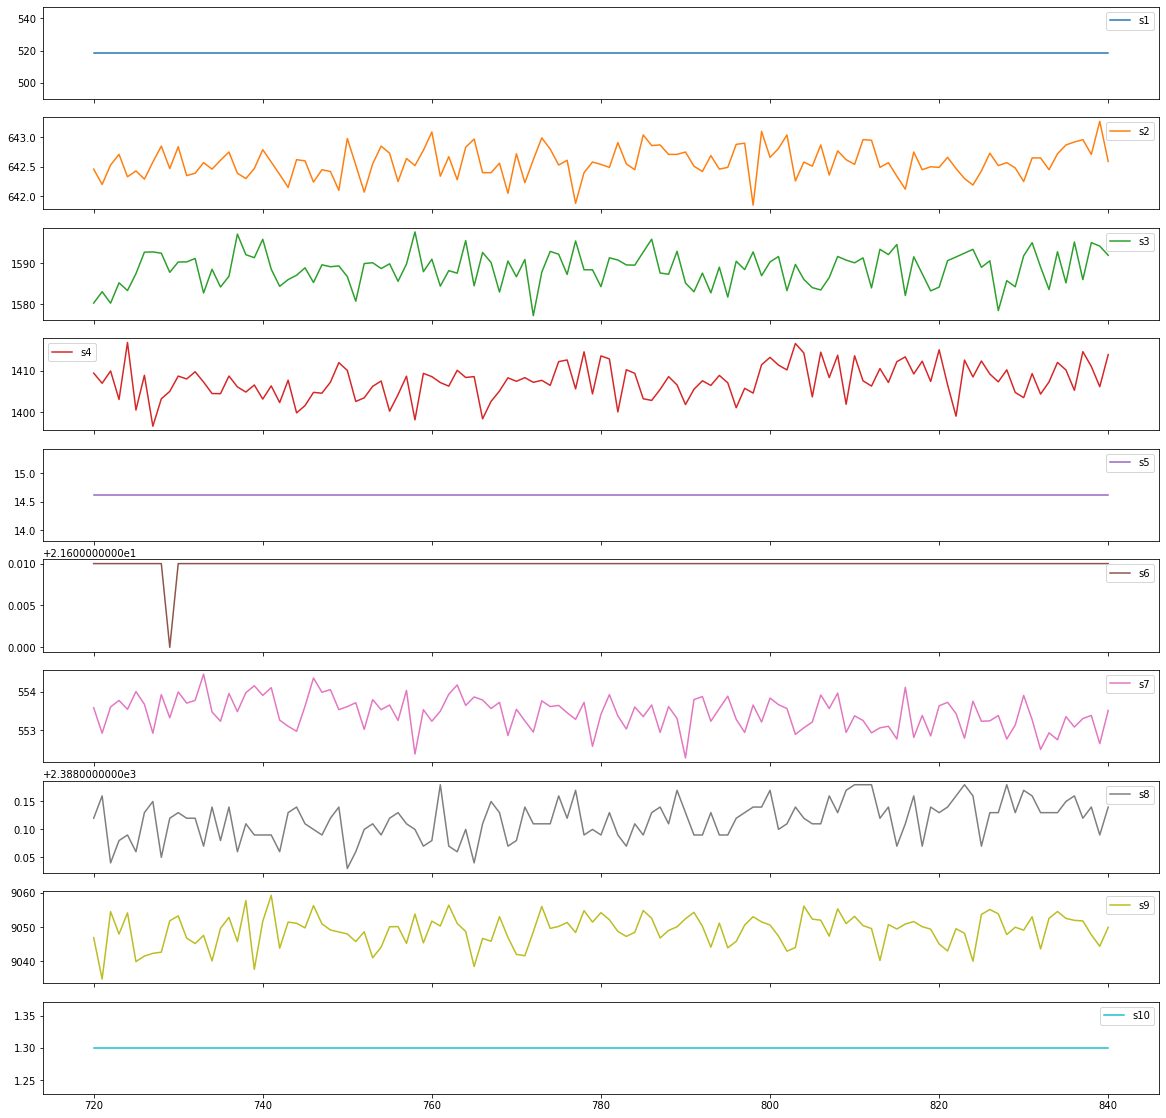

In [29]:
# plotting sensor data for engine ID 8 prior to a failure point - sensors 1-10 
ax1 = engine_id8_120cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

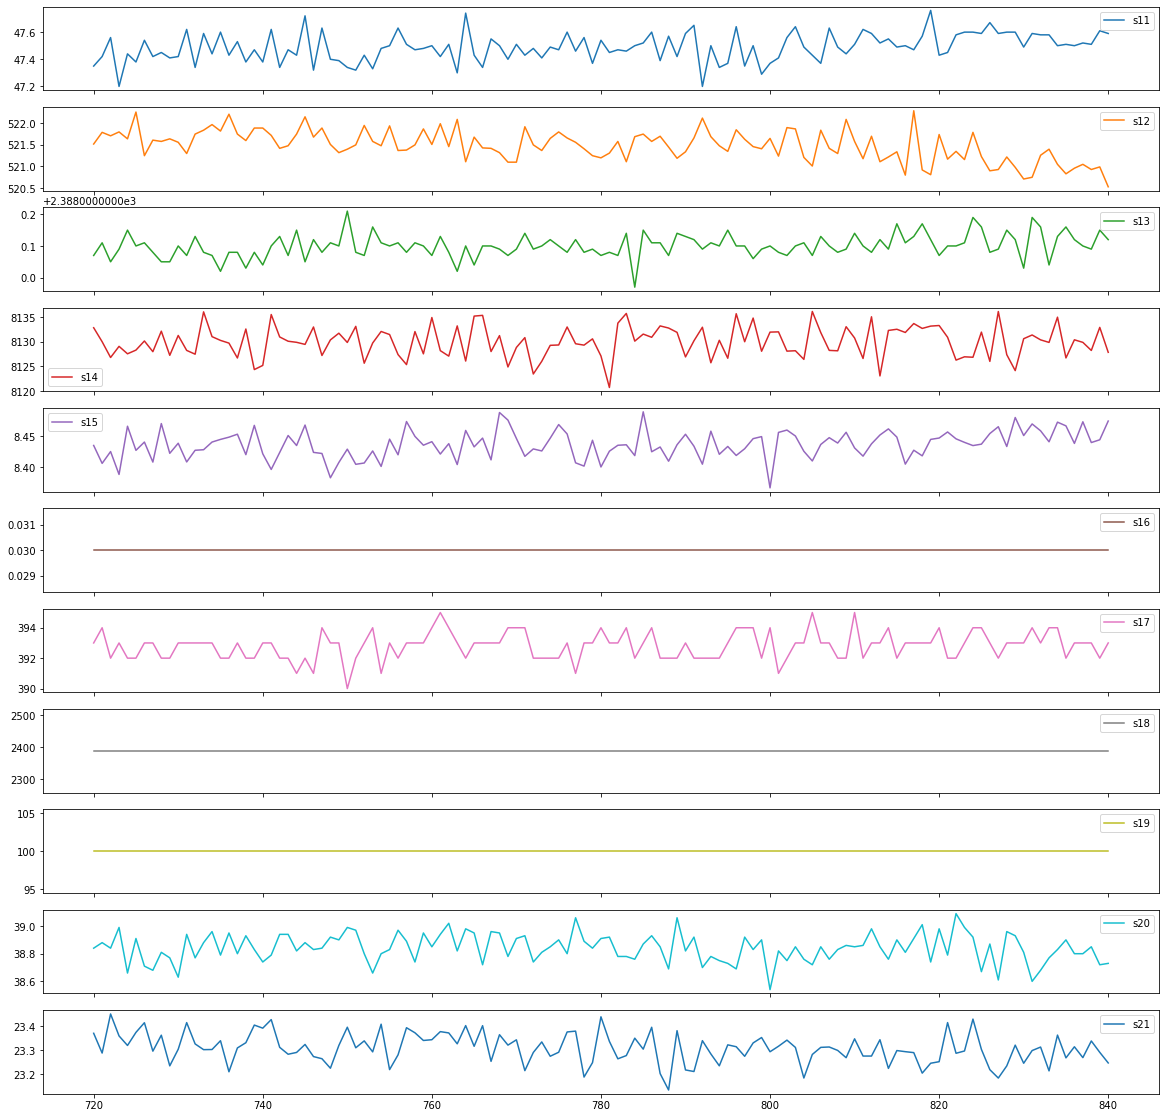

In [30]:
# plotting sensor data for engine ID 8 prior to a failure point - sensors 11-21 
ax2 = engine_id8_120cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

## Train and Test Sequences

In [31]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [32]:
# pick the feature columns 
# sensor_cols = ['s' + str(i) for i in range(1,22)]
# sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [33]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [34]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(8631, 120, 17)

In [35]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [36]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(8631, 1)

In [39]:
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
results = {}
for num_cells in [30, 40, 50,60,70,80,90,100]:
    for dropout_rate in [0, 0.1, 0.2,0.3,0.4]:
        for lr in [1e-4, 1e-3, 1e-2]:
            print('Running with', num_cells, 
                  'LSTM cells, dropout =', dropout_rate, 
                  'and learning rate =', lr, '...')

            # build network
            model = Sequential()
            model.add(LSTM(
                units=num_cells,
                return_sequences=True,
                input_shape=(sequence_length, nb_features)))
            model.add(Dropout(dropout_rate))
            model.add(LSTM(
                units=num_cells,
                return_sequences=False))
            model.add(Dropout(dropout_rate))
            model.add(Dense(units=1, activation='relu'))
            model.add(Activation("relu"))
            optimiser = RMSprop(lr=lr)
            model.compile(loss="mse", optimizer=optimiser, metrics=['mse'])

            # fit network for a maximum of 200 epochs with early stopping (patience=10)
            history = model.fit(seq_array, label_array, epochs=40, batch_size=200, validation_split=0.05, verbose=1,
                             callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])
            

            # get training and validation loss at best epoch (number of epochs - patience)
            num_epochs = len(history.history['val_loss'])
            best_epoch = num_epochs - 10
            train_mse = history.history['loss'][best_epoch]
            val_mse = history.history['val_loss'][best_epoch] 
            results[(num_cells, dropout_rate, lr, best_epoch)] = {'train_mse': train_mse, 
                                                                  'val_mse': val_mse}                                                                                          
            print('Train MSE =', train_mse, ', Validation MSE =', val_mse)        
            print('+----------------------------------------------------------------------+')

val_results = {key: results[key]['val_mse'] for key in results.keys()}
num_cells, dropout_rate, lr, num_epochs = min(val_results, key=val_results.get)
print('Best parameters:', num_cells, 
        'LSTM cells, training for', num_epochs, 
        'epochs with dropout =', dropout_rate, 
        'and learning rate =', lr)

#Best parameters: num_cells=50, dropout_rate=0.1, lr=0.01

Running with 30 LSTM cells, dropout = 0 and learning rate = 0.0001 ...


NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [38]:
num_cells=50
dropout_rate=0.1
lr=0.01

## Model

In [ ]:
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         units=num_cells,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(dropout_rate))
model.add(LSTM(
          units=num_cells,
          return_sequences=False))
model.add(Dropout(lr))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
optimiser = RMSprop(lr=lr)
model.compile(loss="mse", optimizer=optimiser, metrics=['mse'])

In [ ]:
print(model.summary())

## Training the Model

In [ ]:
%%time
# fit the network
hist = model.fit(seq_array, label_array, epochs=40, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Epoch.png', dpi=1200) 
plt.show()

## Results on Train Set

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

## Results on Test Set

In [ ]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

In [ ]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [ ]:
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

In [ ]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

In [ ]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('MSE: {}'.format(scores_test[1]))

In [ ]:
results_df = pd.DataFrame([[scores_test[1]],],
                         columns = ['MSE'],
                         index = ['LSTM'])
results_df

## Plot of Predictions vs True RUL Values

In [ ]:
y_pred_test = model.predict(seq_array_test_last, verbose=0)

import matplotlib.pyplot as plt2
%matplotlib inline
plt2.figure()

plt2.plot(y_pred_test, color='red', label='Prediction')
plt2.plot(label_array_test_last, color='blue', label='Ground Truth')
plt2.xlabel('Machine ID')
plt2.ylabel('Remaining Useful Lifetime')
plt2.legend(loc='upper left')

plt2.savefig('plot.png', dpi=1200) 
plt2.show()